In [1]:
import importlib
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from numpy.random import default_rng
import pandas as pd
import scipy.stats
import seaborn as sns
from scipy.special import expit
from sklearn import linear_model, metrics
from sklearn.metrics import auc, plot_roc_curve, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, StratifiedKFold

from mapra import prep
from mapra.prep import save

sns.set_theme(style='white')


### for a given number n, build a linear regression from the n columns with the highest `abs()` in the spearman correlation to the measurements
### or use the highest linear coefficients

In [8]:
importlib.reload(prep)
data = prep.dataset()
npr = data.fetch_numpy_distances()
spearman_rhos = data.fetch_spearman_rhos(npr)
delta_labels = data.order
'''
The first column indicates the metric,
the second the value,
the rest is the embedding diff
'''


/home/quirin/PYTHON/mapra


/home/quirin/PYTHON/mapra/mapra/prep.py:41: RuntimeWarning: unexpected FASTA filename: /home/quirin/PYTHON/mapra/all_sequences_prothermdb.fasta
  warnings.warn('unexpected FASTA filename: ' + str(fasta), RuntimeWarning)


loading from /home/quirin/PYTHON/mapra/pkl/h5_slice_0.pkl


'\nThe first column indicates the metric,\nthe second the value,\nthe rest is the embedding diff\n'

In [158]:
# loop either over the test_size or the number of selected columns

test_sizes = [.4, .2, 0]
column_numbers = [64, 1024]

if True:
    desc = '%d columns'
    params = column_numbers
    test_size = .2
else:
    desc = 'test size: %.1f'
    params = test_sizes
    n_columns = 256

In [161]:
store = dict()
for row, param in enumerate(params):

    # sort out which one we're looping
    if desc.startswith('%d'):
        n_columns = param
    elif desc.startswith('t'):
        test_size = param
    else:
        assert False

    ars = list()
    models = list()
    sizes = list()
    all_cols = list()
    for i, delta in enumerate(delta_labels):
        # select the rows for this delta, and cleave off the delta column
        dnpr = npr[npr[:, 0] == i, 1:]

        # select the correct, best-fitting columns
        rhos = abs(spearman_rhos[delta])
        cols = np.argpartition(rhos, -n_columns)[-n_columns:]
        all_cols.append(cols)

        # select the correct columns, shift because the measured value is in column 0
        dnpr = dnpr[:, [0] + [c + 1 for c in cols]]

        # split into features and labels
        X, y = dnpr[:, 1:], dnpr[:, 0].reshape(-1, 1)

        if test_size:
            # split into test and training data
            X, X_test, y, y_true = train_test_split(
                X, y, test_size=test_size, random_state=35)
        else:
            # use the entire set for both training and testing -> over-fitting
            X, X_test, y, y_true = X, X, y, y
        sizes.append((X.shape[0], X_test.shape[0]))

        regr = linear_model.LinearRegression()
        regr.fit(X, y)

        # make a prediction
        y_pred = regr.predict(X_test)

        # save
        ars.append(np.hstack((np.full(y_pred.shape, i), y_pred, y_true)))
        models.append(regr)

    store[row] = ars, models, sizes, all_cols
'done'


'done'

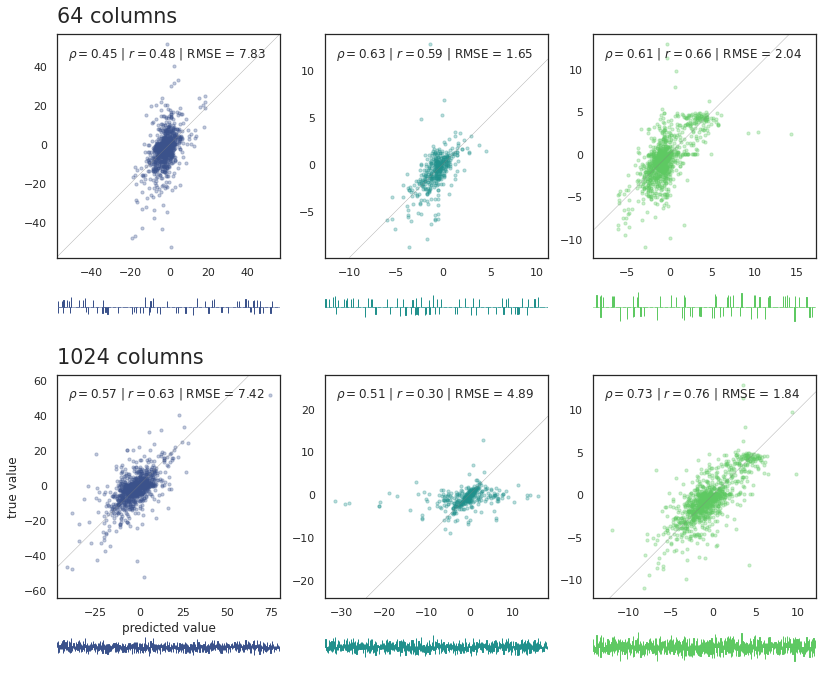

In [162]:
fig, axes = plt.subplots(2 * len(params), 3, figsize=(13.6, 6 * len(params)),
                         gridspec_kw={'height_ratios': [1, .25] * len(params), 'width_ratios': [1, 1, 1]})
cmap = sns.color_palette('viridis', 3)

for row, param in enumerate(params):
    ars, models, sizes, all_cols = store[row]

    for i, (ax, ax_cor, ar, delta, siz, cols) in enumerate(
            zip(axes[2 * row, :], axes[2 * row + 1, :], ars, delta_labels, sizes, all_cols)):
        sns.regplot(ax=ax,
                    x=ar[:, 1], y=ar[:, 2],
                    color=cmap[i],
                    # marker='+',
                    scatter_kws={'s': 10, 'alpha': .3},
                    fit_reg=False, logistic=True)

        ax.set(aspect=1, box_aspect=1)
        # ax.set(title=data.tex_lookup[delta] + [' [°C]', ' [kcal/mol]', ' [kcal/mol]'][i])
        ax.axline((0, 0), slope=1, lw=.5, color='.5', alpha=.6)

        # correlations
        sp, pval = scipy.stats.spearmanr(ar[:, 1:], axis=0)
        pcorr = np.corrcoef(ar[:, 1:], rowvar=False)[0, 1]
        rmse = mean_squared_error(ar[:, 2], ar[:, 1], squared=False)
        r2 = r2_score(ar[:, 2], ar[:, 1])

        # ax.text(.05, .7, data.tex_lookup[delta] + '\n'
        #         + r"$\rho = $" + f'{sp:.2f}, ' + r"$r = $" + f'{pcorr:.2f}\nRMSE = {rmse:.2f}\nr² = {r2:.2f}',
        #         transform=ax.transAxes)
        ax.text(.05, .9, ''  # data.tex_lookup[delta] + f' | {siz[0]} : {siz[1]}\n'
                + r"$\rho = $" + f'{sp:.2f} | ' + r"$r = $" + f'{pcorr:.2f} | RMSE = {rmse:.2f}',
                transform=ax.transAxes)

        # ax_cor.axvline(x=512, lw=.5, color='.5', alpha=.8)
        ax_cor.bar(list(range(1024)), [co if idx in cols else 0 for idx, co in enumerate(spearman_rhos[delta])],
                   edgecolor=cmap[i], alpha=1)
        ax_cor.set_xlim(-1, 1024)
        ax_cor.set_axis_off()
        ax_cor.set_ylim(-1, .5)

        axes[2 * row, 0].set_title(desc % param, loc='left', fontsize='xx-large', pad=12)

# fig.subplots_adjust(bottom=0.002)
axes[-2, 0].set(ylabel='true value', xlabel='predicted value')
save(fig, f'linear_regr_{desc % param}.png')

In [165]:
for ax in axes[3, :]:
    fig.delaxes(ax)
fig
save(fig, f'linear_regr_{desc % param}_noaxes.png')



ValueError: Given element not contained in the stack

In [170]:
axes[2, 0].set_title('all 1024 columns', loc='left', fontsize='xx-large', pad=12)
save(fig, f'linear_regr_{desc % param}_noaxes.png')

### generate a lineplot / optimize the number of columns

In [186]:
cors = {delta: list() for delta in delta_labels}

for i, delta in enumerate(delta_labels):
    # select the rows for this delta, and cleave off the delta column
    dnpr = npr[npr[:, 0] == i, 1:]

    # split into features and labels
    X, y = dnpr[:, 1:], dnpr[:, 0].reshape(-1, 1)

    if test_size:
        # split into test and training data
        X, X_test, y, y_true = train_test_split(
            X, y, test_size=test_size, random_state=35)
    else:
        # use the entire set for both training and testing -> over-fitting
        X, X_test, y, y_true = X, X, y, y

        # select the correct, best-fitting columns
    rhos = abs(spearman_rhos[delta])
    cors_now = cors[delta]

    for n_columns in range(4, 1024, 4):
        print(n_columns, end=' ')
        if not n_columns % 100:
            print('\n')
        cols = np.argpartition(rhos, -n_columns)[-n_columns:]

        # select the correct con_columns
        X_ = X[:, cols]
        X_test_ = X_test[:, cols]

        regr = linear_model.LinearRegression()
        regr.fit(X_, y)

        # make a prediction
        y_pred = regr.predict(X_test_)

        # correlations
        try:
            ar = np.hstack((y_pred, y_true))
        except Exception as ex:
            print(ex)
        sp, pval = scipy.stats.spearmanr(ar, axis=0)
        pcorr = np.corrcoef(ar, rowvar=False)[0, 1]
        rmse = mean_squared_error(y_true, y_pred, squared=False)
        r2 = r2_score(y_true, y_pred)
        cors_now.append((sp, pcorr, rmse, r2))
'done'

4 8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 72 76 80 84 88 92 96 100 

104 108 112 116 120 124 128 132 136 140 144 148 152 156 160 164 168 172 176 180 184 188 192 196 200 

204 208 212 216 220 224 228 232 236 240 244 248 252 256 260 264 268 272 276 280 284 288 292 296 300 

304 308 312 316 320 324 328 332 336 340 344 348 352 356 360 364 368 372 376 380 384 388 392 396 400 

404 408 412 416 420 424 428 432 436 440 444 448 452 456 460 464 468 472 476 480 484 488 492 496 500 

504 508 512 516 520 524 528 532 536 540 544 548 552 556 560 564 568 572 576 580 584 588 592 596 600 

604 608 612 616 620 624 628 632 636 640 644 648 652 656 660 664 668 672 676 680 684 688 692 696 700 

704 708 712 716 720 724 728 732 736 740 744 748 752 756 760 764 768 772 776 780 784 788 792 796 800 

804 808 812 816 820 824 828 832 836 840 844 848 852 856 860 864 868 872 876 880 884 888 892 896 900 

904 908 912 916 920 924 928 932 936 940 944 948 952 956 960 964 968 972 976 980 984 988 992 996 1000 

1004 

'done'

# TODO reorder train-test and selecting columns?

In [191]:
with open(Path('.').resolve().parent / 'txts' / 'cors.txt', 'w') as file:
    file.write(str(cors))

In [242]:
# seaborn: df
df = pd.DataFrame.from_dict(cors)
df = df.melt(ignore_index=False, var_name='delta')
df[['Spearman\'s ρ', 'Pearson\'s $r$', 'RMSE', 'r2']] = pd.DataFrame(df.value.tolist(), index=df.index)
df = df.drop(columns=['value', 'Pearson\'s $r$', 'r2'])
df['number of columns'] = 4 * df.index
df.to_csv(Path('.').resolve().parent / 'txts' / 'cors.csv')
df = df.melt(id_vars=['delta', 'number of columns'],
             value_name='y', var_name='metric')
df

,delta,number of columns,metric,y
0,dtemp,0,Spearman's ρ,0.368067
1,dtemp,4,Spearman's ρ,0.386959
2,dtemp,8,Spearman's ρ,0.380428
3,dtemp,12,Spearman's ρ,0.397848
4,dtemp,16,Spearman's ρ,0.416726
...,...,...,...,...
1525,h2o,1000,RMSE,1.825875
1526,h2o,1004,RMSE,1.833869
1527,h2o,1008,RMSE,1.834942
1528,h2o,1012,RMSE,1.831763


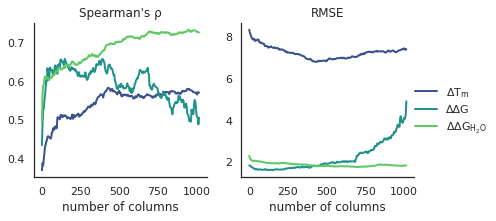

In [331]:
# seaborn: plot
relabel = lambda legend: [t.set_text(data.tex_lookup[t.get_text()]) for t in legend.texts]

g = sns.relplot(data=df, x='number of columns', y='y', kind='line',
                hue='delta', palette='viridis', hue_order=delta_labels,
                col='metric', facet_kws=dict(sharey=False),  #, margin_titles=True),
                aspect=1, lw=2, height=3, legend=True)
g.set_ylabels('')
g.set_titles('{col_name}')

g.legend.set_title('')
# g.legend.set_bbox_to_anchor((1.05,.5))
[l.set_linewidth(2) for l in g.legend.legendHandles]
relabel(g.legend)
save(g, 'spearman_rmse.png')

In [333]:
# matplotlib solution: df
df = pd.DataFrame.from_dict(cors)
df = df.melt(ignore_index=False, var_name='delta')
df[['spearman', 'pearson', 'RMSE', 'r2']] = pd.DataFrame(df.value.tolist(), index=df.index)
df = df.drop(columns=['value'])
df['x'] = 4 * df.index
df

,delta,spearman,pearson,RMSE,r2,x
0,dtemp,0.368067,0.364396,8.300054,0.131072,0
1,dtemp,0.386959,0.402737,8.158347,0.160489,4
2,dtemp,0.380428,0.422993,8.070422,0.178487,8
3,dtemp,0.397848,0.446066,7.971848,0.198433,12
4,dtemp,0.416726,0.460044,7.909223,0.210977,16
...,...,...,...,...,...,...
250,h2o,0.730920,0.759776,1.825875,0.541075,1000
251,h2o,0.728678,0.757991,1.833869,0.537048,1004
252,h2o,0.727797,0.757624,1.834942,0.536505,1008
253,h2o,0.728144,0.758263,1.831763,0.538110,1012


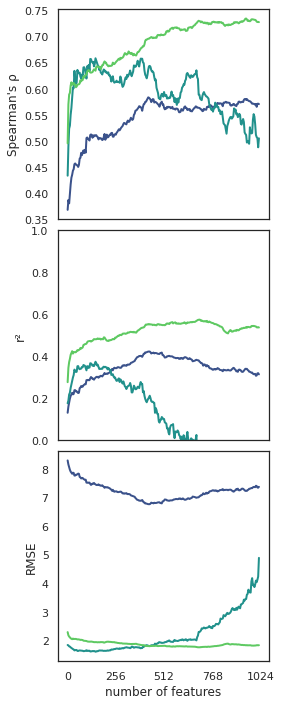

In [389]:
# matplotlib solution: plot
fig, axes = plt.subplots(3, 1, figsize=(4, 12), sharex=True)
cmap = sns.color_palette('viridis', 3)
for ax, metric, label in zip(axes, ['spearman', 'r2', 'RMSE'],
                             ['Spearman\'s ρ', 'r²', 'RMSE']):
    sns.lineplot(data=df, x='x', y=metric, ax=ax,
                 legend=False, lw=2,
                 hue='delta', palette='viridis', hue_order=delta_labels,
                 )
    if metric == 'r2':
        ax.set_ylim((0, 1))
        # ax.axhline(0, lw=1, color='.5', alpha=.8)
    ax.set(xlabel='', ylabel=label, box_aspect=1, xticks=[0, 256, 512, 768, 1024])
axes[-1].set_xlabel('number of features')
fig.subplots_adjust(hspace=.05)
save(fig, 'spearman_r2_rmse.png')


38 55 105 122 150 201 228 261 303 316 362 378 418 451 470 501 535 581 611 654 678 695 749 782 807 837 852 883 920 958 978 1023 31 70 86 122 147 199 232 247 294 306 348 373 423 442 479 510 543 568 609 650 671 694 720 756 786 818 851 899 937 971 996 1023 26 77 100 

135 167 203 230 269 289 321 344 398 417 447 474 504 548 574 610 645 684 698 741 780 798 824 857 890 932 952 1002 1019 loop 0 done
18 48 80 132 155 185 227 242 289 323 337 373 412 441 494 510 548 564 617 630 680 703 733 767 801 824 851 889 943 952 997 1016 42 63 98 118 163 191 230 247 291 330 350 373 402 459 480 501 537 584 603 643 681 694 747 776 794 823 859 882 925 963 1000 

1023 19 68 83 117 174 183 226 261 298 306 362 396 422 445 472 515 549 570 613 629 664 688 729 758 810 843 875 911 932 958 994 1020 loop 1 done
31 56 102 142 149 177 220 253 285 309 341 375 418 456 479 502 541 577 621 635 663 704 721 762 789 825 852 889 923 946 987 1023 19 76 108 142 147 176 239 269 297 307 357 391 409 460 488 501 546 570 617 636 683 699

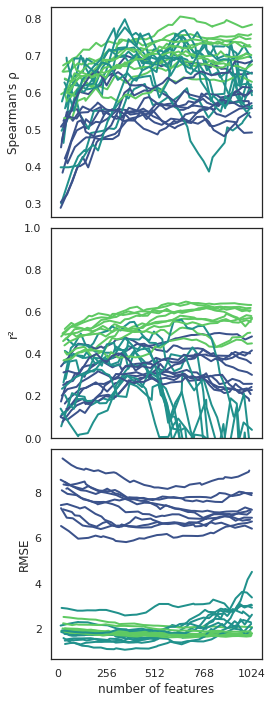

In [500]:
# do this multiple times
fig, axes = plt.subplots(3, 1, figsize=(4, 12), sharex=True)
cmap = sns.color_palette('viridis', 3)
odf = pd.DataFrame()
rng = np.random.default_rng(12345)
test_size = .05

for loop in range(10):
    cors = {delta: list() for delta in delta_labels}

    for i, delta in enumerate(delta_labels):
        # select the rows for this delta, and cleave off the delta column
        dnpr = npr[npr[:, 0] == i, 1:]

        # split into features and labels
        X, y = dnpr[:, 1:], dnpr[:, 0].reshape(-1, 1)

        if test_size:
            # split into test and training data
            X, X_test, y, y_true = train_test_split(
                X, y, test_size=test_size)
        else:
            # use the entire set for both training and testing -> over-fitting
            X, X_test, y, y_true = X, X, y, y

            # select the correct, best-fitting columns
        rhos = abs(spearman_rhos[delta])
        cors_now = cors[delta]

        step = 32
        for n_columns in range(step, 1025, step):
            n_columns += rng.integers(low=-step / 2, high=step / 2, size=1)[0]
            # make sure it's legal
            n_columns = max(0, min(1023, n_columns))
            print(n_columns, end=' ')
            if not n_columns % 100:
                print('\n')
            cols = np.argpartition(rhos, -n_columns)[-n_columns:]

            # select the correct con_columns
            X_ = X[:, cols]
            X_test_ = X_test[:, cols]

            regr = linear_model.LinearRegression()
            regr.fit(X_, y)

            # make a prediction
            y_pred = regr.predict(X_test_)

            # correlations
            try:
                ar = np.hstack((y_pred, y_true))
            except Exception as ex:
                print(ex)
            sp, pval = scipy.stats.spearmanr(ar, axis=0)
            pcorr = np.corrcoef(ar, rowvar=False)[0, 1]
            rmse = mean_squared_error(y_true, y_pred, squared=False)
            r2 = r2_score(y_true, y_pred)
            cors_now.append((n_columns, sp, pcorr, rmse, r2))

    # matplotlib solution: df
    df = pd.DataFrame.from_dict(cors)
    df = df.melt(ignore_index=False, var_name='delta')
    df[['x', 'spearman', 'pearson', 'RMSE', 'r2']] = pd.DataFrame(df.value.tolist(), index=df.index)
    df = df.drop(columns=['value'])
    # df['x'] = step * df.index
    odf = pd.concat((odf, df))
    odf.to_csv(Path('.').resolve().parent
               / 'txts' / f'cors_all_{test_size}.csv')

    for ax, metric, label in zip(axes, ['spearman', 'r2', 'RMSE'],
                                 ['Spearman\'s ρ', 'r²', 'RMSE']):
        sns.lineplot(data=df, x='x', y=metric, ax=ax,
                     legend=False, lw=2,
                     hue='delta', palette='viridis', hue_order=delta_labels,
                     )
        if metric == 'r2':
            ax.set_ylim((0, 1))
            # ax.axhline(0, lw=1, color='.5', alpha=.8)
        ax.set(xlabel='', ylabel=label, box_aspect=1, xticks=[0, 256, 512, 768, 1024])
    axes[-1].set_xlabel('number of features')
    fig.subplots_adjust(hspace=.05)
    save(fig, f'loops/spearman_r2_rmse_loop_{loop}.png')
    print(f'loop {loop} done')


In [501]:
odf

,delta,x,spearman,pearson,RMSE,r2
0,dtemp,38,0.421428,0.410780,8.479472,0.165019
1,dtemp,55,0.443754,0.434905,8.377879,0.184907
2,dtemp,105,0.520362,0.477511,8.175567,0.223798
3,dtemp,122,0.524901,0.489528,8.114799,0.235294
4,dtemp,150,0.503357,0.494232,8.090295,0.239906
...,...,...,...,...,...,...
27,h2o,880,0.740420,0.793928,1.882525,0.624550
28,h2o,917,0.742607,0.792027,1.887795,0.622445
29,h2o,956,0.753029,0.793594,1.880535,0.625344
30,h2o,991,0.744864,0.789507,1.898022,0.618344


In [502]:
df = odf.drop(columns='pearson')
df = df.melt(id_vars=['delta', 'x'],
             value_name='y', var_name='metric')
df

,delta,x,metric,y
0,dtemp,38,spearman,0.421428
1,dtemp,55,spearman,0.443754
2,dtemp,105,spearman,0.520362
3,dtemp,122,spearman,0.524901
4,dtemp,150,spearman,0.503357
...,...,...,...,...
2875,h2o,880,r2,0.624550
2876,h2o,917,r2,0.622445
2877,h2o,956,r2,0.625344
2878,h2o,991,r2,0.618344


TypeError: No loop matching the specified signature and casting was found for ufunc lstsq_n

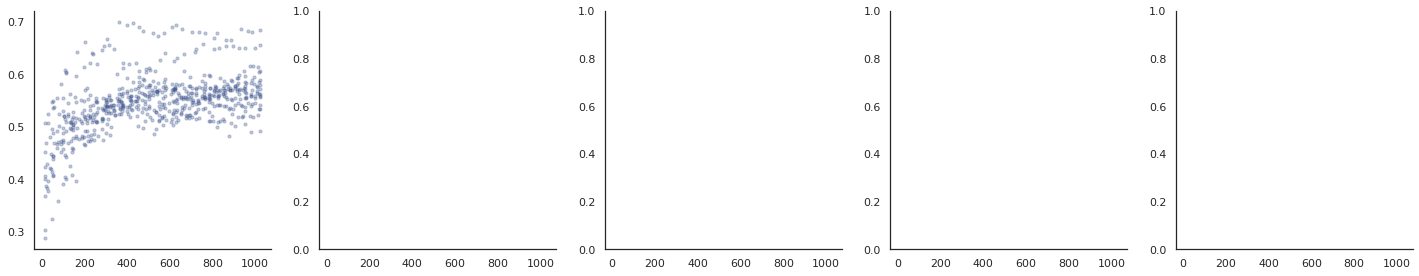

In [11]:
g = sns.FacetGrid(data=df,  # col='delta', col_order=delta_labels,
                  col='metric', height=4, aspect=1,
                  hue='delta', hue_order=delta_labels, palette='viridis',
                  margin_titles=True, sharex=True, sharey=False)
g.map_dataframe(sns.regplot, x='x', y='y', order=4,
                scatter_kws={'s': 10, 'alpha': .3}, )
g.set(xticks=[0, 256, 512, 768, 1024])
g.set(ylim=(0, None), xlim=(-10, 1040))
for j in [0, 2]:
    g.axes[0, j].set(ylim=(0, 1))

g.set_titles(col_template='', row_template='{row_name}')
# for i, ax in enumerate(g.axes[0,]):
#     ax.set_title(data.tex_lookup[delta_labels[i]]
#                  + [' [°C]', ' [kcal/mol]', ' [kcal/mol]'][i], pad=12)
for ax, lab in zip(g.axes[0, :], ['Spearman\'s ρ', 'RMSE', 'r²']):
    ax.set_title(lab)
g.tight_layout()
save(g, f'facetgrid_loops_test_{test_size}.png')



In [47]:
dfs = list()
for test_size in [.2, .05]:
    ndf = pd.read_csv(Path('.').resolve().parent
                      / 'txts' / f'cors_all_{test_size}.csv')\
        .drop(columns=['Unnamed: 0'])
    if 'metric' in ndf.columns:
        ndf = ndf.drop(columns=['metric', 'y'])
        ndf = ndf.loc[~pd.isna(ndf.RMSE)]
    ndf['test_size'] = test_size
    ndf.to_csv(Path('.').resolve().parent
                      / 'txts' / f'cors_all_{test_size}.csv')
    ndf = ndf.melt(id_vars=['delta', 'x', 'test_size'],
                   value_name='y', var_name='metric')
    dfs.append(ndf)

In [48]:
df = pd.concat(dfs)
df


,delta,x,test_size,metric,y
0,dtemp,38,0.20,spearman,0.480232
1,dtemp,55,0.20,spearman,0.488450
2,dtemp,105,0.20,spearman,0.520403
3,dtemp,122,0.20,spearman,0.519454
4,dtemp,150,0.20,spearman,0.517829
...,...,...,...,...,...
2875,h2o,880,0.05,r2,0.624550
2876,h2o,917,0.05,r2,0.622445
2877,h2o,956,0.05,r2,0.625344
2878,h2o,991,0.05,r2,0.618344


/home/quirin/anaconda3/envs/skl/lib/python3.9/site-packages/seaborn/axisgrid.py:132: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self.fig.legend(handles, labels, **kwargs)


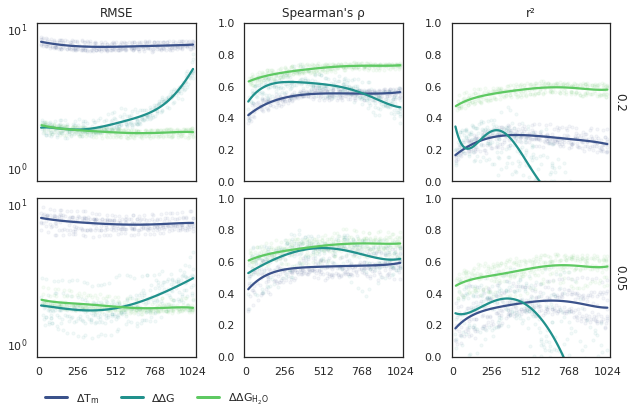

In [132]:
sns.set_theme(style='white')
import matplotlib.lines as mlines
relabel = lambda legend: [t.set_text(data.tex_lookup[t.get_text()]) for t in legend.texts]

g = sns.FacetGrid(data=df,  # col='delta', col_order=delta_labels,
                  row='test_size', row_order=[.2, .05],
                  col='metric', col_order=['RMSE', 'spearman', 'r2'],
                  height=3, # aspect=1,
                  hue='delta', hue_order=delta_labels, palette='viridis',
                  margin_titles=True, sharex=True, sharey='col')
g.map_dataframe(sns.regplot, x='x', y='y', fit_reg=True,
                order=5, ci=False, # x_bins=16,
                scatter_kws={'s': 10, 'alpha': .05})

# mess around with the legend
cmap = sns.color_palette('viridis', 3)
handles = list()
for de, co in zip(delta_labels, cmap):
    handles.append(mlines.Line2D([],[], color=co, label=data.tex_lookup[de], linewidth=3))

g.add_legend(title='', bbox_to_anchor=(.32, .02), ncol=3,
             handles=handles)

g.set(xticks=[0, 256, 512, 768, 1024])
g.set(xlim=(-10, 1040))

for j in [1, 2]:
    for ax in g.axes[:, j]:
        ax.set(ylim=(0, 1), yticks=[0, .2, .4, .6, .8, 1])
for ax in g.axes[:, 0]:
    ax.set_yscale('log')
    ax.set(ylim=(.8,11))

g.set_titles(col_template='', row_template='{row_name}')
for ax, lab in zip(g.axes[0, :], ['RMSE', 'Spearman\'s ρ', 'r²']):
    ax.set_title(lab)

for ax in g.axes.flatten():
    ax.set(box_aspect=1)
    # Drawing the frame
    for _, spine in ax.spines.items():
        spine.set_visible(True)

# g.tight_layout()
g.fig.subplots_adjust(hspace=-.1)
save(g, f'facetgrid_loops_test_both_better.png')
